# Lab : simplified JPEG encoder/decoder

## Importing Library and usefull functions

In [1]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

## Some Functions to be implemented

In [2]:
def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
  '''
  Encode a list of values using run length encoding
  when 'symbol' is encountered, 
  the next value is 'escape' followed by the number of 'symbol'.
  '''
  a, out = 0, []
  for i in data:
    if i==symbol:
      a+=1
    else:
      if a != 0:
        if a>1:
          out.extend((escape, a))
        else:
          out.append(symbol)
        a=0
      out.append(i)
  if data[-1]==symbol:
    if a>1:
      out.extend((escape, a))
    else:
      out.append(symbol)
  return out

In [3]:
# Testing

print(rlencode([1, 2, 0, 3, 0, 0, 0, 4, 0, 0])) # output : [1, 2, 0, 3, 257, 3, 4, 257, 2]
print(rlencode([1, 2, 0, 3, 0, 0, 0, 4, 0])) # output : [1, 2, 0, 3, 257, 3, 4, 0]

[1, 2, 0, 3, 257, 3, 4, 257, 2]
[1, 2, 0, 3, 257, 3, 4, 0]


In [4]:
def count_symbols(data:list) -> Dict[Any, int]:
  '''
  Compute the frequency of each value in the list.
  '''
  freq = {}
  for i in data:
    if freq.get(i) is None:
      freq[i]=1
    else:
      freq[i]+=1
  return freq

In [5]:
# Testing

freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq) # output: {0: 4, 1: 3, 2: 2, 3: 1}'

{0: 4, 1: 3, 2: 2, 3: 1}


## Given Functions

In [6]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
  '''
  Compute a huffman tree from a frequency table of values
  Return the root node of the tree
  '''
  if freq is None:
    freq: Dict[Any, int] = count_symbols(data)

  # create a list of nodes
  nodes = []
  for symbol, freq in freq.items():
    nodes.append((freq, symbol))

  # sort the list of nodes by count
  nodes.sort(key=lambda x: x[0])

  # create a tree
  while len(nodes) > 1:
    # get the two lowest frequency nodes
    left, right = nodes[:2]
    
    # create a new node with the sum of the frequencies
    new_node_count = left[0] + right[0]
    new_node = (new_node_count, left, right)
    # remove the two lowest frequency nodes
    nodes = nodes[2:]
    # insert the new node
    nodes.append(new_node)
    # sort the nodes by frequency
    nodes.sort(key=lambda x: x[0])

  # return the root node
  return nodes[0]

In [7]:
# Testing

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


### Huffman coding table

In [8]:
def display_table(lines, code:dict, sep='\t'):
  '''
  Display a table of data with columns aligned
  '''
  cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
  for line in lines:
    # adjust each column to its max width
    print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

In [9]:
def display_huffman_table(data, code:dict, sep='\t'):
  counts: dict = count_symbols(data)
  total = sum(counts.values())
  lines = [('Symbol', 'Code', 'Count', 'Frequency')]
  tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
  for k in tmp:
    symbol = f"`{k}`"
    symbol_code = str(counts[k])
    count = str(code[k])
    freq = str(round(100 * counts[k] / total, 2))+'%'
    lines.append((symbol, symbol_code, count, freq))
  display_table(lines, code, sep=sep)

In [10]:
def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
  '''
  Build a huffman table from a huffman tree
  Return a dictionary of symbol:code
  '''
  if path is None:
      path = ''
  table = {}
  if len(node) == 2: # leaf node
    count, symbol = node
    table[symbol] = path
  else: # internal node
    node_left, node_right = node[1], node[2]
    left_path = bintree_to_table(node_left, path + left, left=left, right=right)
    right_path = bintree_to_table(node_right, path + right, left=left, right=right)
    table.update(left_path)
    table.update(right_path)

  return table

In [11]:
# Testing

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)

Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


In [12]:
def construct_huffman_table(data:list) -> dict:
  '''
  Encode a list of values using huffman encoding and return the huffman table
  '''
  counts = count_symbols(data)
  tree = compute_huffman_tree(counts)
  table = bintree_to_table(tree)
  return table

In [13]:
def encode_huffman(data: list, table: dict) -> str:
  '''
  Encode a list of values using the huffman table dictionary
  Return the encoded string
  '''
  out = []
  for i in data:
    out.extend(table[i])
  out = ''.join(out) # list to string
  return out

In [14]:
def decode_huffman(encoded:str, table: dict) -> np.ndarray:
  '''
  Decode a list of values using huffman code dictionary
  '''
  data = []
  i = 0
  while i < len(encoded):
    for k, v in table.items():
      if encoded[i:].startswith(v): # prefix match
        data.append(k)
        i += len(v)
        break
  return np.array(data)

In [15]:
# Testing

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)

Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


# Codage Functions

## Usefull variables

In [16]:
# Zig-zag variables

col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

In [17]:
# Define quantization tables

# luminance quantization table :

qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# chrominance quantization table :

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# Change Image format

In [18]:
def rgbToGray(img):
  """
  Convert a colored image to a grayscale one.
  """
  red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
  # Formula of the Luminance
  return 0.299*red + 0.587*green + 0.114*blue

In [19]:
def rgbToYCbCr(img):
  """
  Convert a rgb image to the yCbCr version.
  """
  yCbCr = img.copy()                                          # To create an oject of the same size
  red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
  yCbCr[:,:,0] = 0.299*red + 0.587*green + 0.114*blue         #Formula of the Luminance
  yCbCr[:,:,1] = -0.1687*red - 0.3313*green + 0.5*blue + 128  #Formula of the chrominance red
  yCbCr[:,:,2] = 0.5*red - 0.4187*green - 0.0813*blue + 128   #Formula of the chrominance blue
  return yCbCr

In [20]:
def ycbcrToRGB(img):
  """
  Convert a yCbCr image to the rgb version.
  """
  rgb = img.copy()                                        # To create an oject of the same size
  y, cb, cr = img[:,:,0], img[:,:,1], img[:,:,2]
  rgb[:,:,0] = y + 1.14020*(cr-128)                       #Formula of the red
  rgb[:,:,1] = y - 0.34414*(cb-128) - 0.71414*(cr-128)    #Formula of the green
  rgb[:,:,2] = y + 1.77200*(cb-128)                       #Formula of the blue
  return rgb

## Functions to encode the image

In [21]:
def padding(img):
  """
  Complete the image to have weight and height multiples of 8 by copying last row/column.
  """
  while img.shape[1] % 8 != 0:
    img = np.insert(img, img.shape[1], img[:, -1], axis=1)
  while img.shape[0] % 8 != 0:
    img = np.insert(img, img.shape[0], img[-1, :], axis=0)
  return img

In [22]:
def numberOfBlock(img):
  """
  Compute a tuple with two element : width and height the number of 8 by 8 block of the original image.
  img should be a "one colour" element (gray, only red, only blue, ...).
  """
  blockSize = 8

  width, height = len(img[0]), len(img)

  block_width = width//8 + 1 if width%8 else width//8
  block_height = height//8 + 1 if height%8 else height//8

  return (block_width, block_height)

In [23]:
def which_quantification_matrix(quality_factor=-1, isCbCr=False):
  """
  Return the quantification matrix, in function of the compression factor
  and if whe should take the chrominance or luminance matrix.
  """
  if quality_factor==-1:
    return (qC if isCbCr else qY)
  
  if quality_factor<50:
    s = 5000/quality_factor
  else:
    s = 200 - 2*quality_factor
  
  return (np.floor((s*qC+500)/500) if isCbCr else np.floor((s*qY+500)/500))

In [24]:
def calculateBlock(block, quality_factor=-1, isCbCr=False):
  """
  For a given block, it will center it, apply the dct, quantify.
  """
  f_block = block + -128
  F_block = cv2.dct(np.float32(f_block),1)
  
  Q = which_quantification_matrix(quality_factor, isCbCr)
  Fc_block = F_block/Q
  
  for l in range(8):
    for h in range(8):
      Fc_block[l][h] = int(Fc_block[l][h])
  return Fc_block

In [25]:
def zigZag(block):
  """
  For a given block, it will return the zigzaged version.
  """
  out = [0]*64
  for i in range(64):
    out[i] = block[lig[i]-1][col[i]-1]
  return out

In [26]:
def to_block(data):
  """
  For a given data list of 64 elements, it returns the block.
  """
  out = [[0 for _ in range(8)] for _ in range(8)]
  for i in range(8):
    out[i]=data[i*8:i*8+8]
  return out

## Huffman encoding image

In [27]:
def construc_Huffman_coding(data):
  """
  For a given data, compute into a tuple :
  - the Huffman code of this data
  - the dictionnary of this huffman code
  """
  out=""
  block_huffman_dict = construct_huffman_table(data)
  block_huffman_encoded = encode_huffman(data, block_huffman_dict)
  out+=block_huffman_encoded
  return (out, block_huffman_dict)

# Decodage Functions

In [28]:
def undo_padding(img, original_width, original_height):
  """
  Return the image from the original size, without the added row / column.
  """
  rows_to_remove = img.shape[1] - original_height
  cols_to_remove = img.shape[0] - original_width

  for _ in range(cols_to_remove):
    img = np.delete(img, -1, axis=0)
  
  for _ in range(rows_to_remove):
    img = np.delete(img, -1, axis=1)
  
  return img

In [29]:
def undo_rlencode(code, escape=257, symbol=0):
  """
  Transform a coded "escape symbol" by the real number of symbols.
  """
  for k in range(len(code)):
    code[k] = int(code[k])
  out = []
  skip = False
  for i in range(len(code)):
    if skip:
      skip = False
    elif code[i] == escape:
      out.extend(symbol for _ in range(round(code[i+1])))
      skip = True
    else:
      out.append(code[i])
  return out

In [30]:
# Testing

print(undo_rlencode([1, 2, 0, 3, 257, 3, 4, 257, 2])) # output :  [1, 2, 0, 3, 0, 0, 0, 4, 0, 0]
print(undo_rlencode([1, 2, 0, 3, 257, 3, 4, 0])) # output : [1, 2, 0, 3, 0, 0, 0, 4, 0]

[1, 2, 0, 3, 0, 0, 0, 4, 0, 0]
[1, 2, 0, 3, 0, 0, 0, 4, 0]


In [31]:
def undo_ZigZag(block):
  """
  For a given zigzaged list, it will return the block.
  """
  out = np.zeros((8,8))
  for k in range(64):
    out[lig[k]-1,col[k]-1] = block[k]
  return out.astype(int)

In [32]:
def undo_calculateBlock(block, quality_factor=-1, isCbCr=False):
  """
  For a given block, it will multiply by the quantification matrix,
  apply the idct and uncenter it.
  """
  
  Q = which_quantification_matrix(quality_factor, isCbCr)
  
  out = block * Q
  out = cv2.idct(np.float32(out),1)
  out = out + 128
  for i in range(8):
    for j in range(8):
      out[i][j] = int(out[i][j])
  return out.tolist()

# Codage part

In [33]:
def encode_image_gray(url, quality_factor=-1):
  """
  Encode an image in gray scale, in function of the given quality_factor.
  """  
  img_original = load_from_url(url)
  img_gray = rgbToGray(img_original)

  img_gray = padding(img_gray)
  width, height = len(img_gray[0]), len(img_gray)

  vRLC = []
  width_block, height_block = numberOfBlock(img_gray)

  for i in range(width_block):
    for j in range(height_block):
      current_block = img_gray[i*8 : i*8+8, j*8 : j*8+8]
      current_block = calculateBlock(current_block, quality_factor)
      current_block = zigZag(current_block)
      current_block = rlencode(current_block)
      vRLC.extend(current_block)
  
  my_image_encoded, my_image_dictionnary = construc_Huffman_coding(vRLC)

  return {"quality_factor": quality_factor,
          "image_width": width,
          "image_height": height,
          "encoded_image": my_image_encoded,
          "encoded_dictionnary": my_image_dictionnary,
          "width_block": width_block,
          "height_block":  height_block
          }

In [34]:
def encode_image_color(url, quality_factor=-1):
  """
  Encode an image in RGB mode, in function of the given quality_factor.
  """
  img_original = load_from_url(url)
  img_red = img_original[:,:,0]
  img_green = img_original[:,:,1]
  img_blue = img_original[:,:,2]
  
  width, height = len(img_red[0]), len(img_red)

  img_red = padding(img_red)
  img_green = padding(img_green)
  img_blue = padding(img_blue)
  

  vRLC = {"red":[img_red, []],
          "green":[img_green, []],
          "blue":[img_blue, []],
          }
  
  width_block, height_block = numberOfBlock(img_red)

  my_image_encoded, my_image_dictionnary = {}, {}

  for key, value in vRLC.items():
    for i in range(width_block):
      for j in range(height_block):
        current_block = value[0][i*8 : i*8+8, j*8 : j*8+8]
        current_block = calculateBlock(current_block, quality_factor)
        current_block = zigZag(current_block)
        current_block = rlencode(current_block)
        vRLC[key][1].extend(current_block)
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])

  return {"quality_factor": quality_factor,
          "image_width": width,
          "image_height": height,
          "encoded_image": my_image_encoded,
          "encoded_dictionnary": my_image_dictionnary,
          "width_block": width_block,
          "height_block":  height_block
          }

In [35]:
def encode_image_yCbCr(url, quality_factor=-1):
  """
  Encode an image in yCbCr mode, in function of the given quality_factor.
  """
  img_original = load_from_url(url)
  img_yCbCr = rgbToYCbCr(img_original)

  img_y = img_yCbCr[:,:,0]
  img_Cb = img_yCbCr[:,:,1]
  img_Cr = img_yCbCr[:,:,2]
  
  width, height = len(img_y[0]), len(img_y)

  img_y = padding(img_y)
  img_Cb = padding(img_Cb)
  img_Cr = padding(img_Cr)
  

  # For each value of vRLC : first is the original part, second is the compressed one, third is
  # a boolean to know what matric to use while compressing.
  vRLC = {"y":[img_y, [], False],
          "Cb":[img_Cb, [], True],
          "Cr":[img_Cr, [], True],
          }
  
  width_block, height_block = numberOfBlock(img_y)

  my_image_encoded, my_image_dictionnary = {}, {}

  for key, value in vRLC.items():
    for i in range(width_block):
      for j in range(height_block):
        current_block = value[0][i*8 : i*8+8, j*8 : j*8+8]
        current_block = calculateBlock(current_block, quality_factor, value[2])
        current_block = zigZag(current_block)
        current_block = rlencode(current_block)
        vRLC[key][1].extend(current_block)
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])
    my_image_encoded[key], my_image_dictionnary[key] = construc_Huffman_coding(vRLC[key][1])

  return {"quality_factor": quality_factor,
          "image_width": width,
          "image_height": height,
          "encoded_image": my_image_encoded,
          "encoded_dictionnary": my_image_dictionnary,
          "width_block": width_block,
          "height_block":  height_block
          }

# Decodage part

In [36]:
def decode_image_gray(encode_dict):
  """
  Decode a grayscale image already encoded. All the informations are on the
  dictionnary that is returned by encode_image_gray.
  """  
  image_compressed = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  
  huffman_decoded = decode_huffman(encode_dict.get("encoded_image"), encode_dict.get("encoded_dictionnary"))
  rlc_decoded = undo_rlencode(huffman_decoded)
  
  for i in range(encode_dict.get("width_block")*encode_dict.get("height_block")):
    indice_width = i%encode_dict.get("width_block")
    indice_height = i//encode_dict.get("height_block")
    
    current_list = rlc_decoded[i*64:i*64+64]
    current_block = undo_ZigZag(current_list)
    current_block = undo_calculateBlock(current_block, encode_dict.get("quality_factor"))
    
    for j in range(8):
      for k in range(8):
        image_compressed[indice_width*8+j, indice_height*8+k] = current_block[k][j]
    image_compressed = image_compressed.astype(np.uint8)
  image_compressed = undo_padding(image_compressed, encode_dict.get("image_width"), encode_dict.get("image_height"))
  
  image_compressed = np.rot90(image_compressed, 3)
  image_compressed = np.fliplr(image_compressed)
  return (image_compressed)

In [37]:
def decode_image_color(encode_dict):
  """
  Decode a RGB image already encoded. All the informations are on the
  dictionnary that is returned by encode_image_color.
  """  
  image_compressed_red = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  image_compressed_green = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  image_compressed_blue = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  
  huffman_decoded = {"red":0,
                     "green":0,
                     "blue":0
                     }

  rlc_decoded = {"red":[],
                 "green":[],
                 "blue":[]
                 }

  colors = ["red", "green", "blue"]
  
  for key, value in huffman_decoded.items():
    current_encoded_image = encode_dict.get("encoded_image").get(key)
    current_encoded_dictionnary = encode_dict.get("encoded_dictionnary").get(key)
    huffman_decoded[key] = decode_huffman(current_encoded_image, current_encoded_dictionnary)
    rlc_decoded[key].extend(undo_rlencode(huffman_decoded[key]))

  for i in range(encode_dict.get("width_block")*encode_dict.get("height_block")):
    indice_width = i%encode_dict.get("width_block")
    indice_height = i//encode_dict.get("height_block")
    
    current_block, current_list = {}, {}
    
    for color in colors:
      current_list[color] = rlc_decoded[color][i*64:i*64+64]
      current_block[color] = undo_ZigZag(current_list[color])
      current_block[color] = undo_calculateBlock(current_block[color], encode_dict.get("quality_factor"))
    
    for j in range(8):
      for k in range(8):
        image_compressed_red[indice_width*8+j, indice_height*8+k] = current_block["red"][k][j]
        image_compressed_green[indice_width*8+j, indice_height*8+k] = current_block["green"][k][j]
        image_compressed_blue[indice_width*8+j, indice_height*8+k] = current_block["blue"][k][j]
    
    image_compressed = np.dstack((image_compressed_red,image_compressed_green,image_compressed_blue))
    image_compressed = image_compressed.astype(np.uint8)
  image_compressed = undo_padding(image_compressed, encode_dict.get("image_width"), encode_dict.get("image_height"))
  
  image_compressed = np.rot90(image_compressed, 3)
  image_compressed = np.fliplr(image_compressed)
  return image_compressed

In [38]:
def decode_image_yCbCr(encode_dict):
  """
  Decode a yCbCr image already encoded. All the informations are on the
  dictionnary that is returned by encode_image_yCbCr.
  """  
  image_compressed_y = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  image_compressed_Cb = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  image_compressed_Cr = np.zeros((encode_dict.get("image_width"), encode_dict.get("image_height")))
  
  huffman_decoded = {"y":0,
                     "Cb":0,
                     "Cr":0
                     }

  rlc_decoded = {"y":[],
                 "Cb":[],
                 "Cr":[]
                 }

  colors = [["y", False] , ["Cb", True], ["Cr", True]]
  
  for key, value in huffman_decoded.items():
    current_encoded_image = encode_dict.get("encoded_image").get(key)
    current_encoded_dictionnary = encode_dict.get("encoded_dictionnary").get(key)
    huffman_decoded[key] = decode_huffman(current_encoded_image, current_encoded_dictionnary)
    rlc_decoded[key].extend(undo_rlencode(huffman_decoded[key]))

  for i in range(encode_dict.get("width_block")*encode_dict.get("height_block")):
    indice_width = i%encode_dict.get("width_block")
    indice_height = i//encode_dict.get("height_block")
    
    current_block, current_list = {}, {}
    
    for element in colors:
      current_list[element[0]] = rlc_decoded[element[0]][i*64:i*64+64]
      current_block[element[0]] = undo_ZigZag(current_list[element[0]])
      current_block[element[0]] = undo_calculateBlock(current_block[element[0]], encode_dict.get("quality_factor"), element[1])
    
    for j in range(8):
      for k in range(8):
        image_compressed_y[indice_width*8+j, indice_height*8+k] = current_block["y"][k][j]
        image_compressed_Cb[indice_width*8+j, indice_height*8+k] = current_block["Cb"][k][j]
        image_compressed_Cr[indice_width*8+j, indice_height*8+k] = current_block["Cr"][k][j]
    
    image_compressed = np.dstack((image_compressed_y,image_compressed_Cb,image_compressed_Cr))
    image_compressed = image_compressed.astype(np.uint8)
  image_compressed = undo_padding(image_compressed, encode_dict.get("image_width"), encode_dict.get("image_height"))
  
  image_compressed = np.rot90(image_compressed, 3)
  image_compressed = np.fliplr(image_compressed)
  return image_compressed

# Calculate loss / MSE, ...

In [39]:
def MSE_gray(url, quality_factor=-1):
  """
  Calculate the MSE of an image (in grayscale), taking into account the quality_factor.
  """
  original_image = load_from_url(url)
  encoded_img = encode_image_gray(url, quality_factor)
  decoded_img = decode_image_gray(encoded_img)
  D = 0
  image_gray = rgbToGray(original_image).astype(np.uint8)
  for i in range(encoded_img.get("image_width")):
    for j in range(encoded_img.get("image_height")):
     D += (int(image_gray[i][j])-int(decoded_img[i][j]))**2
  D = D/(encoded_img.get("image_width")*encoded_img.get("image_height"))
  PSNR = 10*np.log10(255**2/D)
  
  print(f"MSE : {D}")
  print(f"PSNR : {PSNR} \n")

In [40]:
def MSE_color(url, quality_factor=-1):
  """
  Calculate the MSE of an image (in rgb), taking into account the quality_factor.
  """
  original_image = load_from_url(url)
  encoded_img = encode_image_color(url, quality_factor)
  decoded_img = decode_image_color(encoded_img)
  D1, D2, D3 = 0, 0, 0
  original_image = original_image.astype(np.uint8)
  for i in range(encoded_img.get("image_width")):
    for j in range(encoded_img.get("image_height")):
      D1 += (int(original_image[i,j,0])-int(decoded_img[i,j,0]))**2
      D2 += (int(original_image[i,j,1])-int(decoded_img[i,j,1]))**2
      D3 += (int(original_image[i,j,2])-int(decoded_img[i,j,2]))**2
  D = (D1+D2+D3)/(encoded_img.get("image_width")*encoded_img.get("image_height")*3)
  PSNR = 10*np.log10(255**2/D)
  
  print(f"MSE : {D}")
  print(f"PSNR : {PSNR} \n")

In [41]:
def MSE_yCbCr(url, quality_factor=-1):
  """
  Calculate the MSE of an image (in yCbCr), taking into account the quality_factor.
  """
  original_image = load_from_url(url)
  encoded_img = encode_image_yCbCr(url, quality_factor)
  decoded_img = decode_image_yCbCr(encoded_img)
  D1, D2, D3 = 0, 0, 0
  original_image = original_image.astype(np.uint8)
  for i in range(encoded_img.get("image_width")):
    for j in range(encoded_img.get("image_height")):
      D1 += (int(original_image[i,j,0])-int(decoded_img[i,j,0]))**2
      D2 += (int(original_image[i,j,1])-int(decoded_img[i,j,1]))**2
      D3 += (int(original_image[i,j,2])-int(decoded_img[i,j,2]))**2
  D = (D1+D2+D3)/(encoded_img.get("image_width")*encoded_img.get("image_height")*3)
  PSNR = 10*np.log10(255**2/D)
  
  print(f"MSE : {D}")
  print(f"PSNR : {PSNR} \n")

In [42]:
def compression_rate(url, color_mode, quality_factor):
  """
  Calculates the compression ratio defined by :
  the number of bit at the end divided by the original number of bit.
  """
  img_original = load_from_url(url)
  original_number_bits = img_original.shape[0] * img_original.shape[1] * 8
  final_number_bits = 0
  
  if color_mode=="gray":
    image_encoded_dictionnary = encode_image_gray(url, quality_factor)
    final_number_bits = len(image_encoded_dictionnary.get("encoded_image"))
  
  elif color_mode=="rgb":
    image_encoded_dictionnary = encode_image_color(url, quality_factor)
  else:
    image_encoded_dictionnary = encode_image_yCbCr(url, quality_factor)
  
  if color_mode!="gray":
    original_number_bits = original_number_bits * 3
    for key, value in image_encoded_dictionnary.get("encoded_image").items():
      final_number_bits += len(value)
  return original_number_bits/final_number_bits

In [43]:
def plot_compression_rate(url, min=1, max=100, step=1):
  """
  Plot the compression rate of the three colour modes.
  """
  
  # Calculate every compression rate 
  gray_table, rgb_table, yCbCr_table = [], [], []
  X = [i for i in range(min, max, step)]
  for quality_factor in X:
    gray_table.append(compression_rate(url, "gray", quality_factor))
    rgb_table.append(compression_rate(url, "rgb", quality_factor))
    yCbCr_table.append(compression_rate(url, "yCbCr", quality_factor))
  
  fig = plt.figure()
  
  # Set up the grid
  ax = fig.add_subplot(1, 1, 1)
  major_ticksx = np.arange(0, 101, 10)
  minor_ticksx = np.arange(0, 101, 1)
  major_ticksy = np.arange(0, 55, 5)
  minor_ticksy = np.arange(0, 55, 1)
  ax.set_xticks(major_ticksx)
  ax.set_xticks(minor_ticksx, minor=True)
  ax.set_yticks(major_ticksy)
  ax.set_yticks(minor_ticksy, minor=True)
  ax.grid(which='minor', alpha=0.2)
  ax.grid(which='major', alpha=0.7)

  # Plotting our datas
  
  plt.plot(X, gray_table, label="Image en nuance de gris")
  plt.plot(X, rgb_table, label="Image en couleur RGB")
  plt.plot(X, yCbCr_table, label="Image en chrominance yCbCr")
  plt.legend(bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
  plt.ylabel("Taux de compression")
  plt.xlabel("Facteur de qualité")
  plt.title(f"Taux de compression en fonction du facteur de qualité")

# Results

## Show different version of the original image

In [44]:
# Choosing an image for the results

lenna_url = "http://www.lenna.org/len_std.jpg"

lenna_img_original = load_from_url(lenna_url)

(256, 256) RGB None 0 255


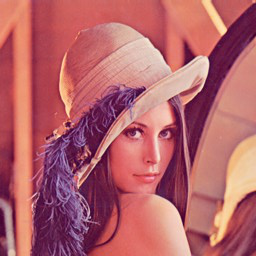

(256, 256) L None 20 239


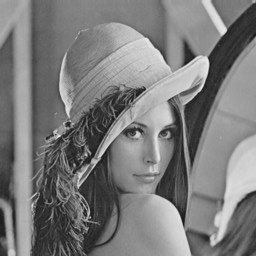

(256, 256) RGB None 20 239


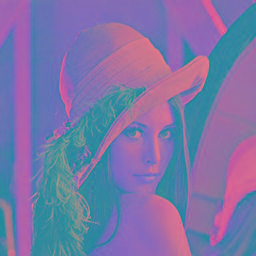

In [ ]:
# Showing the chosen image, in rgb / grayscale / YCbCr

show(load_from_url(lenna_url))
show(rgbToGray(load_from_url(lenna_url)).astype(np.uint8))
show(rgbToYCbCr(load_from_url(lenna_url)).astype(np.uint8))

Voici l'image en ne conservant que les nuances de rouge :
(256, 256) RGB None 0 255


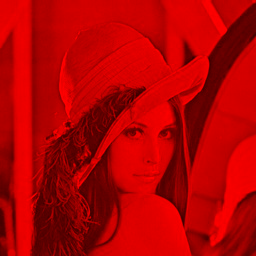

Voici l'image en ne conservant que les nuances de vert :
(256, 256) RGB None 0 240


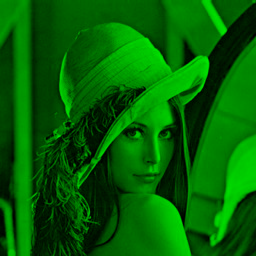

Voici l'image en ne conservant que les nuances de bleu :
(256, 256) RGB None 0 224


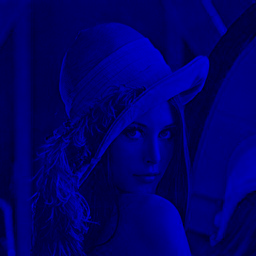

In [ ]:
# Showing the chosen image, in red / green / blue

red, green, blue = lenna_img_original[:,:,0], lenna_img_original[:,:,1], lenna_img_original[:,:,2]

blank = 0 * red

print("Voici l'image en ne conservant que les nuances de rouge :")
show(np.dstack((red, blank, blank)))
print("Voici l'image en ne conservant que les nuances de vert :")
show(np.dstack((blank, green, blank)))
print("Voici l'image en ne conservant que les nuances de bleu :")
show(np.dstack((blank, blank, blue)))

Voici l'image en ne conservant que la luminance (nuance de gris) :
(256, 256) L None 20 239


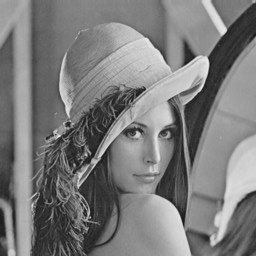

Voici l'image en ne conservant que la chrominance bleue (en intensité) :
(256, 256) L None 77 156


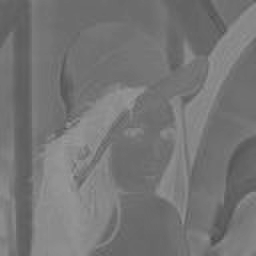

Voici l'image en ne conservant que la chrominance rouge (en intensité) :
(256, 256) L None 130 204


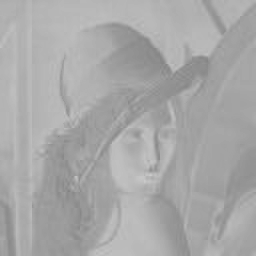

In [ ]:
# Showing the chosen image, in red / green / blue

lenna_img_yCbCr = rgbToYCbCr(lenna_img_original).astype(np.uint8)

y, cb, cr = lenna_img_yCbCr[:,:,0], lenna_img_yCbCr[:,:,1], lenna_img_yCbCr[:,:,2]

blank = 0 * y

print("Voici l'image en ne conservant que la luminance (nuance de gris) :")
show(y)
print("Voici l'image en ne conservant que la chrominance bleue (en intensité) :")
show(cb)
print("Voici l'image en ne conservant que la chrominance rouge (en intensité) :")
show(cr)

## Show the decoded versions of the image, with compression rate

(256, 256) RGB None 0 255


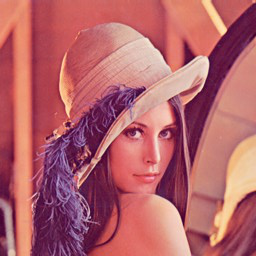

(256, 256) RGB None 0 255


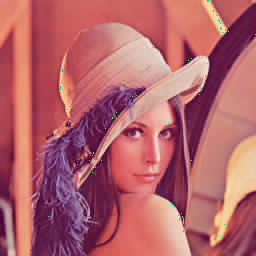

(256, 256) RGB None 0 255


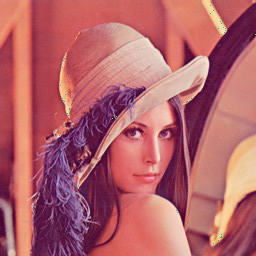

In [ ]:
show(lenna_img_original)

show(decode_image_color(encode_image_color(lenna_url, 10)))

show(decode_image_color(encode_image_color(lenna_url, 90)))

(256, 256) L None 20 239


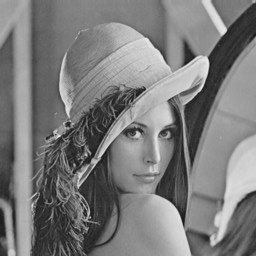

(256, 256) L None 10 245


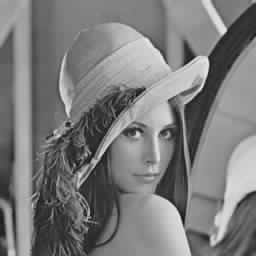

(256, 256) L None 19 237


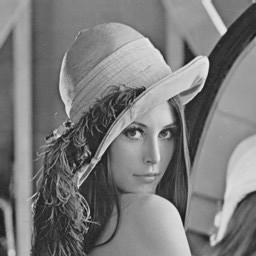

In [ ]:
show(rgbToGray(lenna_img_original).astype(np.uint8))

show(decode_image_gray(encode_image_gray(lenna_url, 10)))

show(decode_image_gray(encode_image_gray(lenna_url, 90)))

(256, 256) L None 2 232


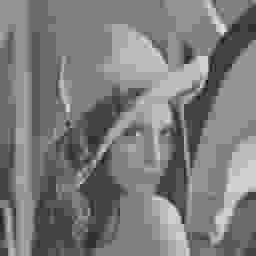

In [ ]:
show(decode_image_gray(encode_image_gray(lenna_url, 1)))

(256, 256) RGB None 20 239


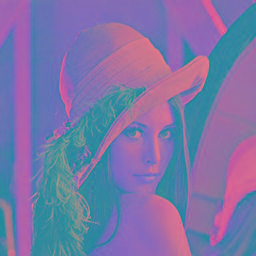

(256, 256) RGB None 10 241


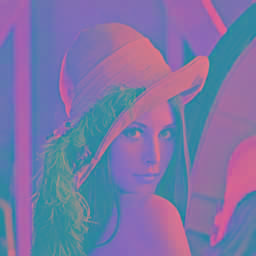

(256, 256) RGB None 16 244


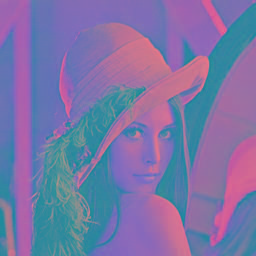

In [ ]:
show(rgbToYCbCr(lenna_img_original).astype(np.uint8))

show(decode_image_yCbCr(encode_image_yCbCr(lenna_url, 10)))

show(decode_image_yCbCr(encode_image_yCbCr(lenna_url, 40)))

(256, 256) RGB None 0 255


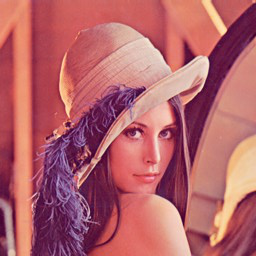

(256, 256) RGB None 0 255


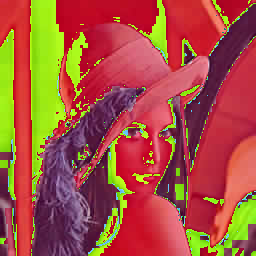

(256, 256) RGB None 0 255


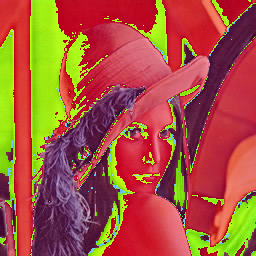

In [ ]:
show(lenna_img_original)

show(ycbcrToRGB(decode_image_yCbCr(encode_image_yCbCr(lenna_url, 10))).astype(np.uint8))

show(ycbcrToRGB(decode_image_yCbCr(encode_image_yCbCr(lenna_url, 40))).astype(np.uint8))

## Compression rate

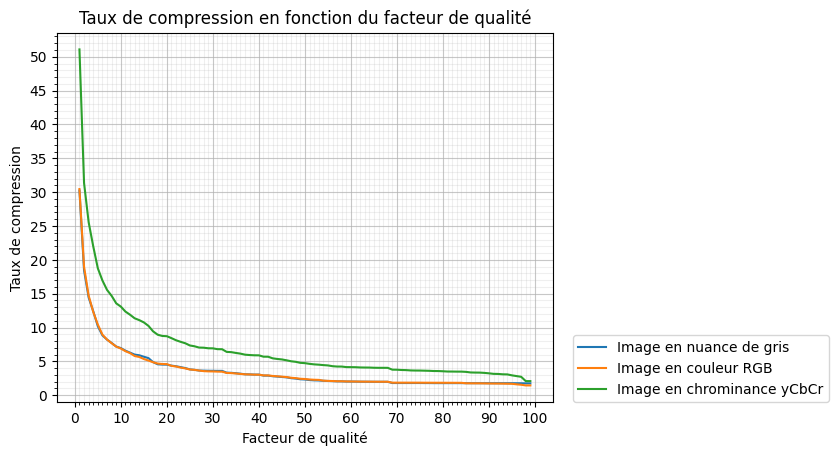

In [ ]:
plot_compression_rate("http://www.lenna.org/len_std.jpg")

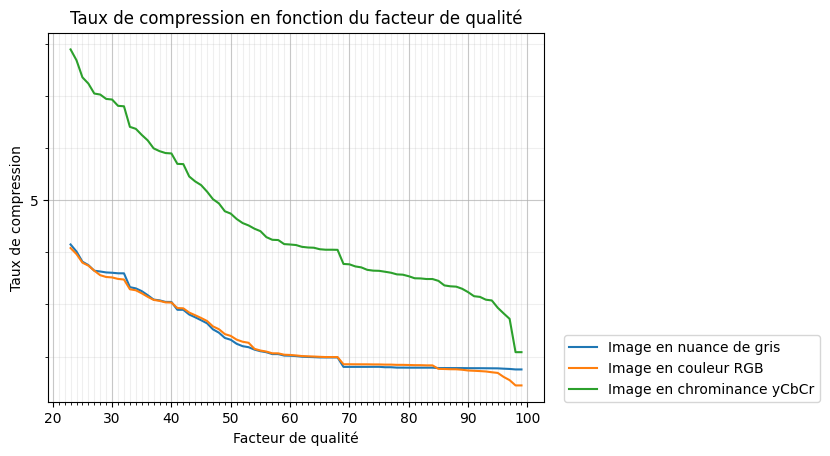

In [ ]:
plot_compression_rate("http://www.lenna.org/len_std.jpg", min=23)

# MSE

In [52]:
mse_quality_factor = 35

print(f"Calcul du MSE et du PSNR pour un facteur de qualité de {mse_quality_factor} :\n")

print("Pour l'image en nuance de gris :")
MSE_gray(lenna_url, mse_quality_factor)

print("Pour l'image en RGB :")
MSE_color(lenna_url, mse_quality_factor)

print("Pour l'image en YCbCr :")
MSE_yCbCr(lenna_url, mse_quality_factor)

Calcul du MSE et du PSNR pour un facteur de qualité de 35 :

Pour l'image en nuance de gris :
MSE : 15.06353759765625
PSNR : 36.35153385103894 

Pour l'image en RGB :
MSE : 36.69623819986979
PSNR : 32.48458814675059 

Pour l'image en YCbCr :
MSE : 4398.415176391602
PSNR : 11.697841398663897 



# Other tests

In [ ]:
testBlock = [[i for i in range(8)] for _ in range(8)]

print(f"Le bloc d'origine est :\n{testBlock}")

testList_zz = zigZag(testBlock)

print(f"\nLa liste zig-zaggé est :\n{testList_zz}")

testBlock_zz = to_block(testList_zz)

print(f"\nLe block zig-zaggé est :\n{testBlock_zz}")

testBlock_undo_zz = undo_ZigZag(testList_zz)

print(f"\nLe bloc dé-zig-zaggé est :\n{testBlock_undo_zz}")

Le bloc d'origine est :
[[0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7]]

La liste zig-zaggé est :
[0, 1, 0, 0, 1, 2, 3, 2, 1, 0, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, 0, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 7, 6, 5, 4, 5, 6, 7, 7, 6, 7]

Le block zig-zaggé est :
[[0, 1, 0, 0, 1, 2, 3, 2], [1, 0, 0, 1, 2, 3, 4, 5], [4, 3, 2, 1, 0, 0, 1, 2], [3, 4, 5, 6, 7, 6, 5, 4], [3, 2, 1, 0, 1, 2, 3, 4], [5, 6, 7, 7, 6, 5, 4, 3], [2, 3, 4, 5, 6, 7, 7, 6], [5, 4, 5, 6, 7, 7, 6, 7]]

Le bloc dé-zig-zaggé est :
[[0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]
 [0 1 2 3 4 5 6 7]]


In [ ]:
# Testing if padding works properly

url_test_padding = "https://media.istockphoto.com/id/1322277517/fr/photo/herbe-sauvage-dans-les-montagnes-au-coucher-du-soleil.jpg?s=170667a&w=0&k=20&c=smRW8b-F8YXvHR2kdU46ISPVxzFFaVhkvckcoNAs2yM="

image_test_padding = load_from_url(url_test_padding)

image_test_padding_w, image_test_padding_h, _ = image_test_padding.shape

print(f"La taille originale de l'image est :\n{image_test_padding.shape}")

image_test_padding_with_padding = padding(image_test_padding)

print(f"La taille originale avec padding est :\n{image_test_padding_with_padding.shape}")

image_test_padding_rebuilt = undo_padding(image_test_padding_with_padding, image_test_padding_w, image_test_padding_h)

print(f"La taille originale avec padding est :\n{image_test_padding_rebuilt.shape}")

La taille originale de l'image est :
(339, 509, 3)
La taille originale avec padding est :
(344, 512, 3)
La taille originale avec padding est :
(339, 509, 3)


Image de test originale :

(509, 339) RGB None 0 255


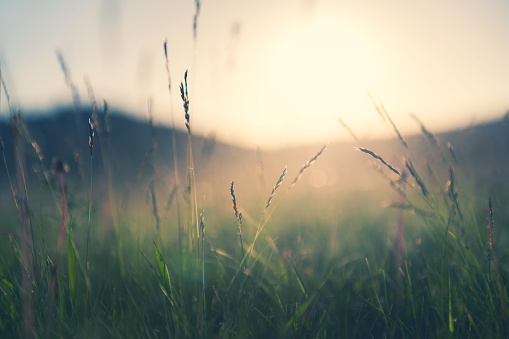


Image de test après padding :

(512, 344) RGB None 0 255


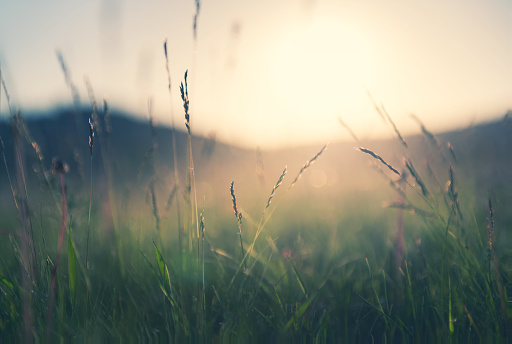


Image de test reconstruite :

(509, 339) RGB None 0 255


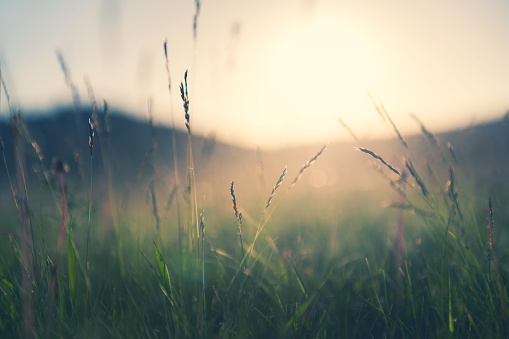

In [ ]:
# Viewing if added (and deleted) rows & columns are the good ones

print("Image de test originale :\n")
show(image_test_padding)

print("\nImage de test après padding :\n")

show(image_test_padding_with_padding)

print("\nImage de test reconstruite :\n")

show(image_test_padding_rebuilt)

# By zooming on the pictures, we clearly see that it's the last column and the last zow
# which are duplicated